In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.utils import class_weight

import cv2

import matplotlib.pyplot as plt
import numpy as np
import os

2024-09-27 14:38:55.126952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 14:38:55.277807: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-27 14:38:55.315671: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-27 14:38:57.791753: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
os.system('nvidia-smi')

Fri Sep 27 14:39:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-PCIE-32GB           Off |   00000000:86:00.0 Off |                    0 |
| N/A   35C    P0             25W /  250W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

0

In [3]:
print(tf.sysconfig.get_build_info())

OrderedDict([('cpu_compiler', '/dt9/usr/bin/gcc'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '11.2'), ('cudnn_version', '8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', True)])


In [4]:
img = cv2.imread("Data/tire_textures/testing_data/cracked/Cracked-208.jpg")
img.shape

(632, 632, 3)

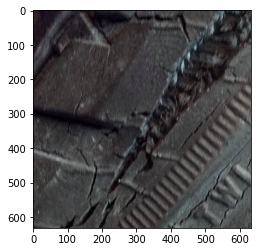

In [5]:
plt.imshow(img)

In [6]:
train_dir = "Data/tire_textures/training_data"
test_dir = "Data/tire_textures/testing_data"

In [7]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1/255.,                                                        
                                                           rotation_range=0.2,
                                                           width_shift_range=0.2,
                                                           height_shift_range=0.2,
                                                           zoom_range = 0.5, 
                                                           horizontal_flip=True,
                                                            )

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1/255.)

In [8]:
train_data = train_gen.flow_from_directory(train_dir,
                                            target_size = (224,224),
                                            class_mode = "categorical",
                                            batch_size = 64
                                            )
test_data = test_gen.flow_from_directory(test_dir,
                                          target_size = (224,224),
                                          class_mode = "categorical",
                                          batch_size = 64
                                          )

Found 703 images belonging to 2 classes.
Found 327 images belonging to 2 classes.


In [9]:
len(train_data)

11

In [10]:
len(test_data)

6

In [11]:
label_name = list(train_data.class_indices.keys())
label_name

['cracked', 'normal']

2024-09-27 14:39:07.031112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 14:39:07.125289: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


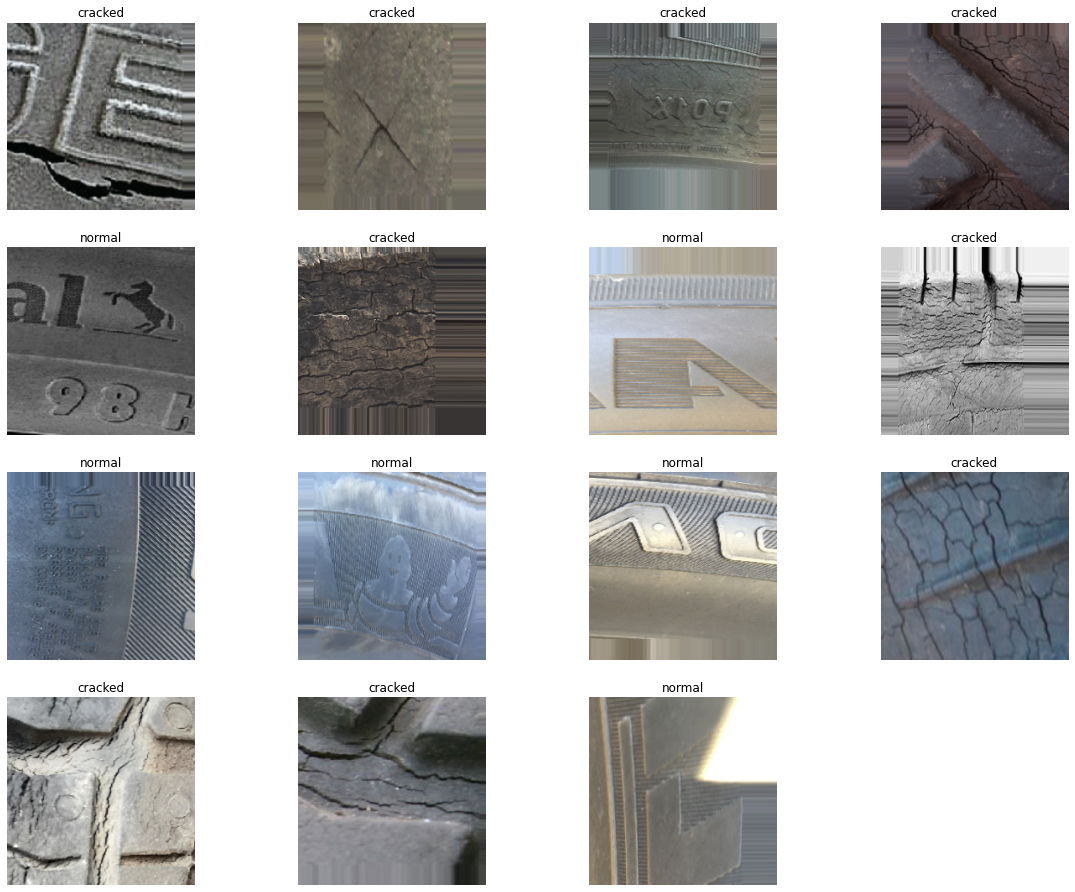

In [12]:
plt.figure(figsize=(20,20))

image, label = next(train_data)
num_images = image.shape[0]
tot_sample = 15

for i in range(tot_sample):
    plt.subplot(5, 4, i+1)
    plt.imshow(image[i])
    plt.title(label_name[tf.argmax(label[i])])
    plt.axis("off")

In [13]:
resnet_base = tf.keras.applications.ResNet50V2(include_top= False)
resnet_base.trainable = False

In [14]:
inputs = tf.keras.Input(shape=(224,224,3))
x = resnet_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(2, activation = "softmax")(x)
resnet_model = tf.keras.Model(inputs,outputs)

In [15]:
resnet_model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

In [16]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max'
)

history = resnet_model.fit(
    train_data,
    epochs = 15,
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks=[model_checkpoint]
)

Epoch 1/15


2024-09-27 14:39:18.011286: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700
2024-09-27 14:39:18.132934: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


11/11 [==============================] - 38s 3s/step - loss: 0.6861 - accuracy: 0.6316 - val_loss: 0.7124 - val_accuracy: 0.6575
Epoch 2/15
11/11 [==============================] - 30s 3s/step - loss: 0.3639 - accuracy: 0.8549 - val_loss: 0.8489 - val_accuracy: 0.6544
Epoch 3/15
11/11 [==============================] - 30s 3s/step - loss: 0.2700 - accuracy: 0.8976 - val_loss: 0.8109 - val_accuracy: 0.6758
Epoch 4/15
11/11 [==============================] - 30s 3s/step - loss: 0.2720 - accuracy: 0.8905 - val_loss: 0.8256 - val_accuracy: 0.6942
Epoch 5/15
11/11 [==============================] - 30s 3s/step - loss: 0.2563 - accuracy: 0.9047 - val_loss: 0.9038 - val_accuracy: 0.6820
Epoch 6/15
11/11 [==============================] - 30s 3s/step - loss: 0.2166 - accuracy: 0.9331 - val_loss: 0.8359 - val_accuracy: 0.6911
Epoch 7/15
11/11 [==============================] - 30s 3s/step - loss: 0.2007 - accuracy: 0.9275 - val_loss: 0.9241 - val_accuracy: 0.6758
Epoch 8/15
11/11 [=============

In [17]:
resnet_model_training = resnet_model.evaluate(train_data)
print(f"Resnet Model Accuracy: {resnet_model_training[1] * 100: 0.2f} %")

11/11 [==============================] - 20s 2s/step - loss: 0.1663 - accuracy: 0.9360
Resnet Model Accuracy:  93.60 %


In [18]:
resnet_model_evaluation = resnet_model.evaluate(test_data)
print(f"Resnet Model Accuracy: {resnet_model_evaluation[1] * 100: 0.2f} %")

6/6 [==============================] - 10s 2s/step - loss: 0.8443 - accuracy: 0.7003
Resnet Model Accuracy:  70.03 %


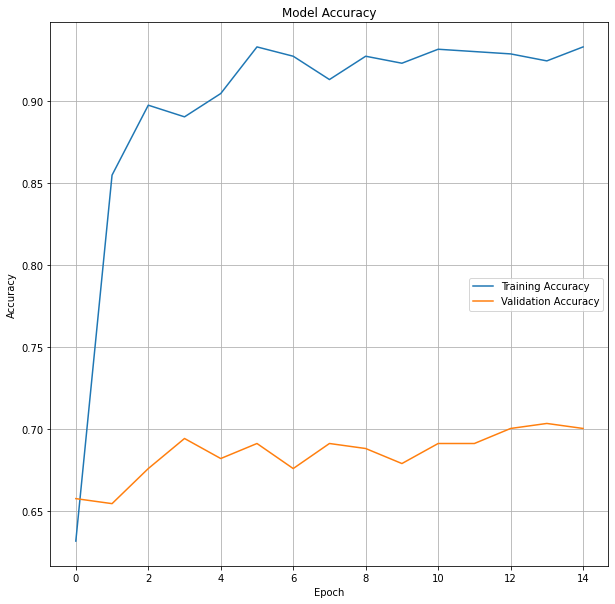

In [19]:
plt.figure(figsize=(10,10))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='center right')
plt.grid(True)
plt.show()

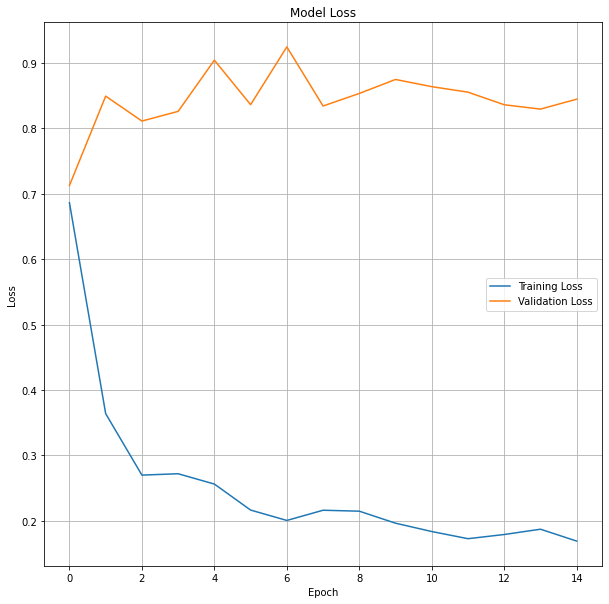

In [20]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='center right')
plt.grid(True)
plt.show()

2/2 [==============================] - 0s 31ms/step


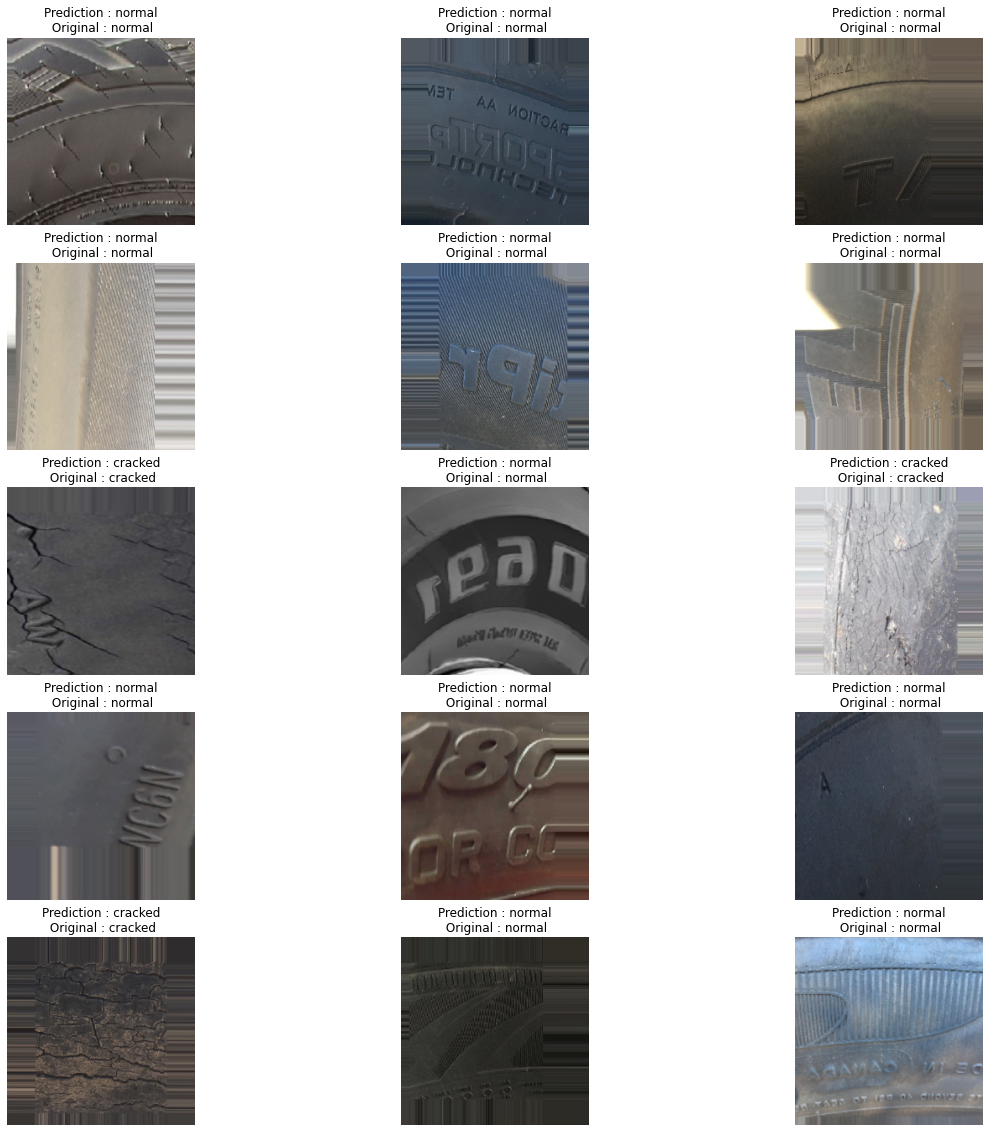

In [21]:
test_label = list(train_data.class_indices.keys())
plt.figure(figsize=(20,20))
tot_sample = 15
correct_predictions = 0

for i in range(tot_sample):
    image,label = next(train_data)
    resnet_pred = resnet_model.predict(image)
    plt.subplot(5, 3, i+1)
    plt.imshow(image[i])
    plt.title(f"Prediction : {test_label[tf.argmax(resnet_pred[i])]}\n Original : {test_label[tf.argmax(label[i])]}")
    plt.axis("off")
    predicted_label = tf.argmax(resnet_pred[i])
    true_label = tf.argmax(label[i])
    if predicted_label == true_label:
        correct_predictions += 1

In [22]:
accuracy = (correct_predictions / tot_sample) * 100
print('Total Prediction by Train Data = ' + str(accuracy) + '%')

Total Prediction by Train Data = 100.0%


2/2 [==============================] - 0s 31ms/step


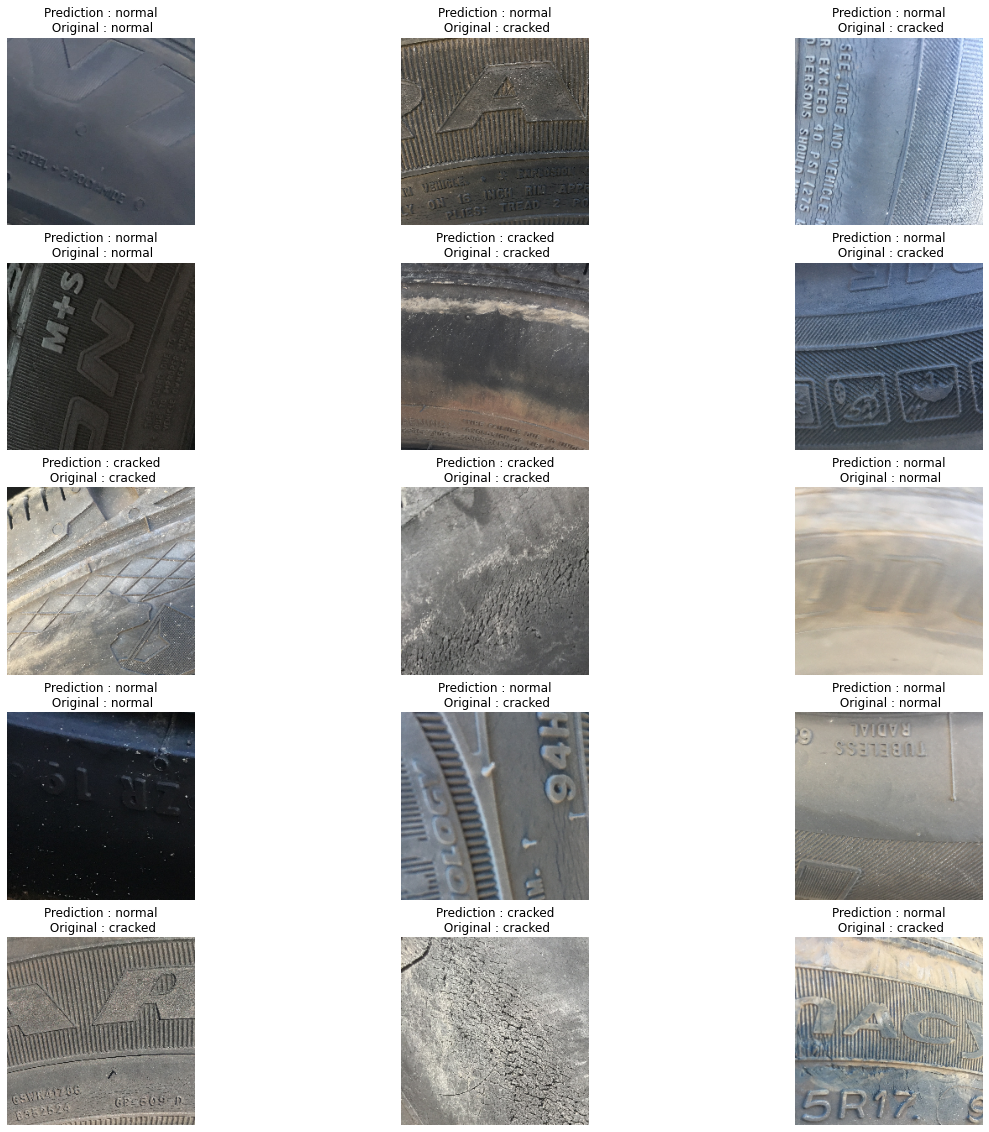

In [23]:
test_label = list(test_data.class_indices.keys())
plt.figure(figsize=(20,20))
tot_sample = 15
correct_predictions = 0
image, label = next(test_data)
for i in range(len(image)):
    if i == tot_sample:
        break
    else:
        resnet_pred = resnet_model.predict(image)
        plt.subplot(5, 3, i+1)
        plt.imshow(image[i])
        plt.title(f"Prediction : {test_label[tf.argmax(resnet_pred[i])]}\n Original : {test_label[tf.argmax(label[i])]}")
        plt.axis("off")
        predicted_label = tf.argmax(resnet_pred[i])
        true_label = tf.argmax(label[i])
        if predicted_label == true_label:
            correct_predictions += 1

In [24]:
accuracy = (correct_predictions / tot_sample) * 100
print('Total Prediction by Test Data = ' + str(accuracy) + '%')

Total Prediction by Test Data = 60.0%


## Tunning

In [25]:
# Adjusted Training Data Generator
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/225.,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    brightness_range=[0.8, 1.2]
)

# Modified Test Data Generator
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/225.)

# Loading Data
train_data = train_gen.flow_from_directory(
    directory=train_dir,  # Use 'directory' keyword
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=16
)

# Validation/Test Data
test_data = test_gen.flow_from_directory(
    directory=test_dir,  # Use 'directory' keyword
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=16
)

inputs = tf.keras.Input(shape=(224,224,3))
x = resnet_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(2, activation = "softmax")(x)
resnet_model = tf.keras.Model(inputs,outputs)

resnet_model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

# Callbacks
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'tun_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max'
)

Found 703 images belonging to 2 classes.
Found 327 images belonging to 2 classes.


In [26]:
# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',  # Specify the strategy
    classes=np.unique(train_data.classes),  # Array of unique class labels
    y=train_data.classes  # Array of class labels for all samples
)

# Convert to dictionary format
class_weights = dict(enumerate(class_weights))

# Print class weights to verify
print("Class Weights:", class_weights)

Class Weights: {0: 1.0749235474006116, 1: 0.9348404255319149}


In [27]:
# Training
history = resnet_model.fit(
    train_data,
    epochs=60,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[model_checkpoint],
    class_weight=class_weights  # Add class weights
)

Epoch 1/60
44/44 [==============================] - 36s 751ms/step - loss: 0.3805 - accuracy: 0.8265 - val_loss: 0.7040 - val_accuracy: 0.7156
Epoch 2/60
44/44 [==============================] - 31s 713ms/step - loss: 0.2254 - accuracy: 0.9218 - val_loss: 0.5803 - val_accuracy: 0.7401
Epoch 3/60
44/44 [==============================] - 30s 698ms/step - loss: 0.1982 - accuracy: 0.9417 - val_loss: 0.7810 - val_accuracy: 0.7217
Epoch 4/60
44/44 [==============================] - 31s 702ms/step - loss: 0.1591 - accuracy: 0.9331 - val_loss: 0.6793 - val_accuracy: 0.7370
Epoch 5/60
44/44 [==============================] - 31s 698ms/step - loss: 0.1485 - accuracy: 0.9388 - val_loss: 0.7359 - val_accuracy: 0.7309
Epoch 6/60
44/44 [==============================] - 31s 696ms/step - loss: 0.1404 - accuracy: 0.9559 - val_loss: 0.6762 - val_accuracy: 0.7401
Epoch 7/60
44/44 [==============================] - 30s 694ms/step - loss: 0.1480 - accuracy: 0.9403 - val_loss: 0.7922 - val_accuracy: 0.7095

In [28]:
resnet_model_training = resnet_model.evaluate(train_data)
print(f"Resnet Model Accuracy Train: {resnet_model_training[1] * 100: 0.2f} %")

44/44 [==============================] - 21s 468ms/step - loss: 0.0275 - accuracy: 0.9929
Resnet Model Accuracy Train:  99.29 %


In [29]:
resnet_model_evaluation = resnet_model.evaluate(test_data)
print(f"Resnet Model Accuracy Eval: {resnet_model_evaluation[1] * 100: 0.2f} %")

21/21 [==============================] - 10s 455ms/step - loss: 0.7933 - accuracy: 0.7737
Resnet Model Accuracy Eval:  77.37 %


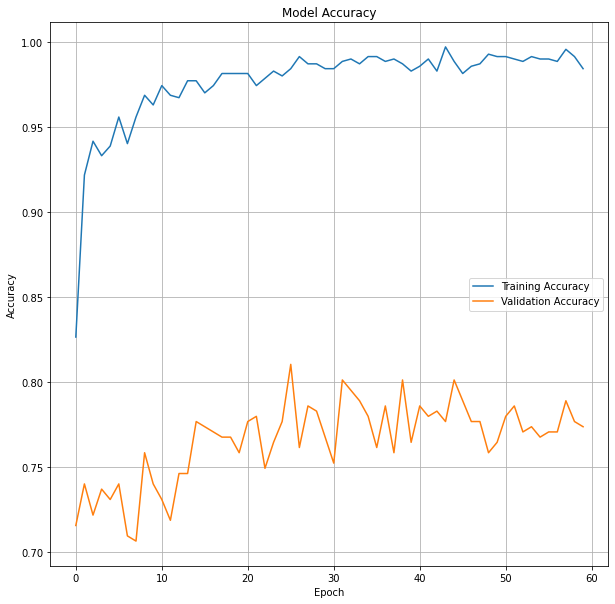

In [30]:
plt.figure(figsize=(10,10))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='center right')
plt.grid(True)
plt.show()

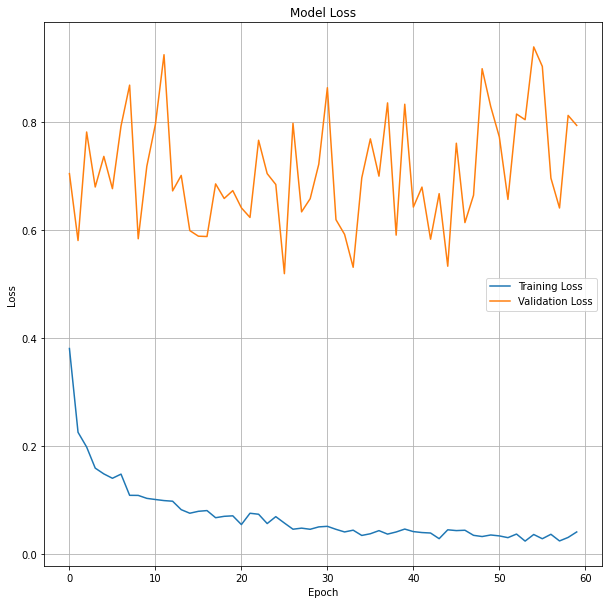

In [31]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='center right')
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 33ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 33ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 30ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 31ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 30ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 30ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 33ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


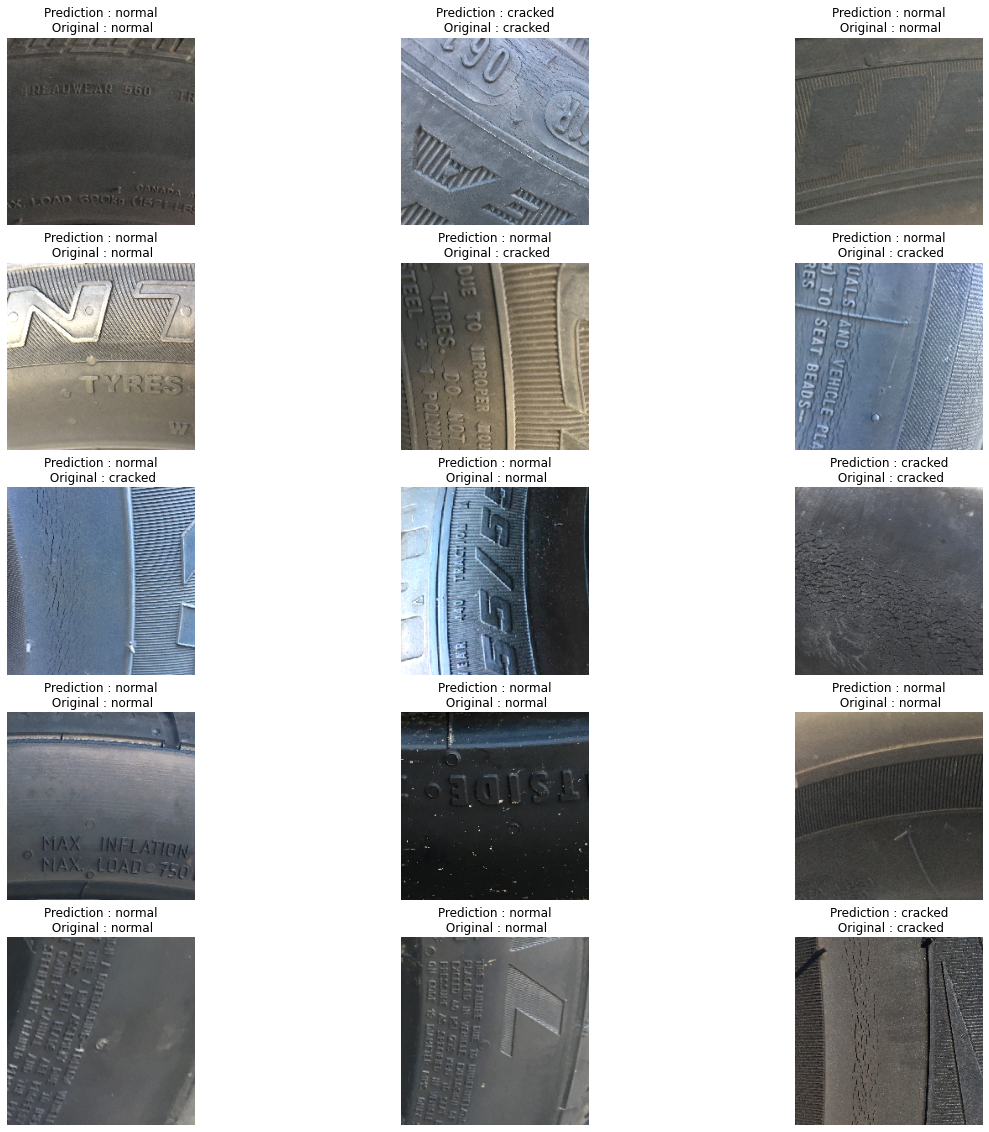

In [32]:
plt.figure(figsize=(20,20))
tot_sample = 15
correct_predictions = 0

for i in range(tot_sample):
    image,label = next(test_data)
    resnet_pred = resnet_model.predict(image)
    plt.subplot(5, 3, i+1)
    plt.imshow(image[i])
    plt.title(f"Prediction : {test_label[tf.argmax(resnet_pred[i])]}\n Original : {test_label[tf.argmax(label[i])]}")
    plt.axis("off")
    predicted_label = tf.argmax(resnet_pred[i])
    true_label = tf.argmax(label[i])
    if predicted_label == true_label:
        correct_predictions += 1

In [33]:
accuracy = (correct_predictions / tot_sample) * 100
print('Total Prediction by Test Data = ' + str(accuracy) + '%')

Total Prediction by Test Data = 80.0%
